In [1]:
# PlacesCNN to predict the scene category, attribute, and class activation map in a single pass
# by Bolei Zhou, sep 2, 2017
# updated, making it compatible to pytorch 1.x in a hacky way

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
import cv2
from PIL import Image


# hacky way to deal with the Pytorch 1.0 update
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf


def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    
    # hacky way to deal with the upgraded batchnorm2D and avgpool layers...
    for i, (name, module) in enumerate(model._modules.items()):
        module = recursion_change_bn(model)
    model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)
    
    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model


# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

# load the test image
img_url = 'https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.pixelstalk.net%2Fwp-content%2Fuploads%2F2016%2F04%2FMountain-wallpaper-HD-pictures-images-photos.jpg&f=1&nofb=1&ipt=f43db112d689f9c87e4fea4b82e49a1a7e4f10fe45e45dae45573aff8dc0bd43&ipo=images'
os.system('wget %s -q -O test.jpg' % img_url)
img = Image.open('test.jpg')
input_img = V(tf(img).unsqueeze(0))

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

print('RESULT ON ' + img_url)

# output the IO prediction
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')

# output the prediction of scene category
print('--SCENE CATEGORIES:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# output the scene attributes
responses_attribute = W_attribute.dot(features_blobs[1])
idx_a = np.argsort(responses_attribute)
print('--SCENE ATTRIBUTES:')
print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))


# generate class activation mapping
print('Class activation map is saved as cam.jpg')
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5
res = cv2.imwrite('cam.jpg', result)

RESULT ON https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.pixelstalk.net%2Fwp-content%2Fuploads%2F2016%2F04%2FMountain-wallpaper-HD-pictures-images-photos.jpg&f=1&nofb=1&ipt=f43db112d689f9c87e4fea4b82e49a1a7e4f10fe45e45dae45573aff8dc0bd43&ipo=images
--TYPE OF ENVIRONMENT: outdoor
--SCENE CATEGORIES:
0.410 -> forest/broadleaf
0.352 -> rainforest
0.052 -> forest_path
0.023 -> swamp
0.011 -> bamboo_forest
--SCENE ATTRIBUTES:
no horizon, natural, trees, vegetation, foliage, leaves, natural light, hiking, camping
Class activation map is saved as cam.jpg


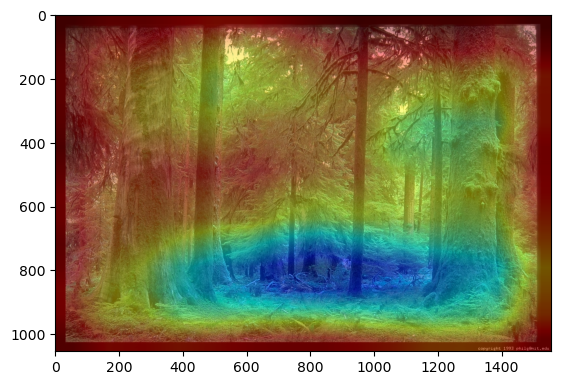

In [2]:
import matplotlib.pyplot as plt
result = (result-result.min())/(result.max()-result.min())
plt.imshow(result)

In [3]:
img = Image.open('test2.jpg')
input_img = V(tf(img).unsqueeze(0))

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

print('RESULT ON ' + img_url)

# output the IO prediction
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')

# output the prediction of scene category
print('--SCENE CATEGORIES:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# output the scene attributes
responses_attribute = W_attribute.dot(features_blobs[1])
idx_a = np.argsort(responses_attribute)
print('--SCENE ATTRIBUTES:')
print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))


# generate class activation mapping
print('Class activation map is saved as cam.jpg')
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
img = cv2.imread('test2.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5
res = cv2.imwrite('cam2.jpg', result)

RESULT ON https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fwww.pixelstalk.net%2Fwp-content%2Fuploads%2F2016%2F04%2FMountain-wallpaper-HD-pictures-images-photos.jpg&f=1&nofb=1&ipt=f43db112d689f9c87e4fea4b82e49a1a7e4f10fe45e45dae45573aff8dc0bd43&ipo=images
--TYPE OF ENVIRONMENT: outdoor
--SCENE CATEGORIES:
0.298 -> mountain_snowy
0.247 -> ski_slope
0.152 -> glacier
0.041 -> snowfield
0.040 -> ice_shelf
--SCENE ATTRIBUTES:
no horizon, natural, trees, vegetation, foliage, leaves, natural light, hiking, camping
Class activation map is saved as cam.jpg


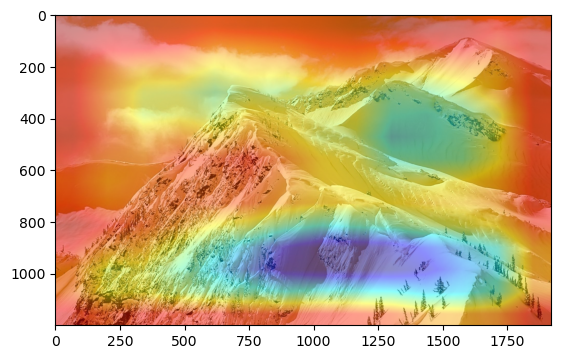

In [4]:
result = (result-result.min())/(result.max()-result.min())
plt.imshow(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


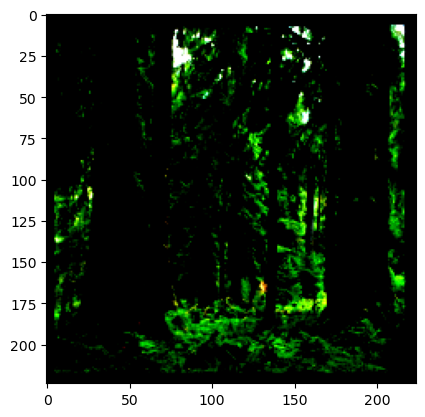

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


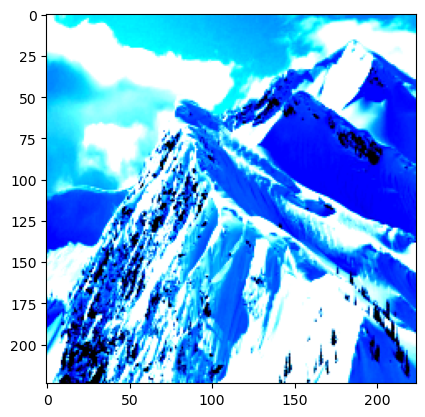

In [13]:
img1 = Image.open('test.jpg')
input_img1 = V(tf(img1).unsqueeze(0))
t1 = input_img1.numpy()
t1 = t1[0].transpose((1, 2, 0))
plt.figure()
plt.imshow(t1)
plt.show()


img2 = Image.open('test2.jpg')
input_img2 = V(tf(img2).unsqueeze(0))
t2 = input_img2.numpy()
t2 = t2[0].transpose((1, 2, 0))

plt.figure()
plt.imshow(t2)
plt.show()

In [23]:
logit1 = model.forward(input_img1)
h_x1 = F.softmax(logit1, 1).data.squeeze()
logit2 = model.forward(input_img2)
h_x2 = F.softmax(logit2, 1).data.squeeze()

probs1, idx1 = h_x1.sort(0, True)
probs2, idx2 = h_x2.sort(0, True)


print(idx2)

tensor([234, 305, 163, 309, 187, 232, 304, 111, 233, 190, 341, 350,  87, 191,
        344, 306, 186, 117, 116,  73,  81,  30, 180, 338,  76, 118, 189,  94,
        258, 348, 342, 141, 243, 279, 150, 175, 140, 194,  50, 192, 178, 359,
        357,  49,  97, 151, 204, 289, 170,  57, 296, 349,  32, 237, 164, 205,
        152, 110, 249, 231, 287, 138, 353,  12, 184, 283, 355, 108, 142,  74,
        214, 173,   9,  16, 213,  77,  58,  40, 288, 277, 181, 104, 103, 132,
         62, 179,  86, 361, 193, 206, 107, 127, 221, 113, 292, 200, 316,  48,
        257, 360, 268,  33,  61, 216, 273, 291, 224, 324, 226, 171, 326,   7,
        167,  93, 207, 242, 239, 197, 196, 209, 323,   0,  84, 308, 299, 351,
        199, 188, 105, 265,   8, 166, 354, 252, 332, 293, 303,   1, 161, 122,
        174, 275, 248, 315, 245, 340, 346,  13, 345, 356, 183, 185,  89,  91,
        334, 241, 131, 282, 201, 272, 339,  69, 364, 247, 271, 278,  60,  59,
        254, 266, 307, 270, 145, 157, 230, 115,  15, 262, 311,  

In [24]:
help(h_x.sort())

Help on Tensor in module torch object:

class Tensor(torch._C._TensorBase)
 |  Method resolution order:
 |      Tensor
 |      torch._C._TensorBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __abs__ = abs(...)
 |  
 |  __array__(self, dtype=None)
 |  
 |  __array_wrap__(self, array)
 |      # Wrap Numpy array again in a suitable tensor when done, to support e.g.
 |      # `numpy.sin(tensor) -> tensor` or `numpy.greater(tensor, 0) -> ByteTensor`
 |  
 |  __contains__(self, element)
 |      Check if `element` is present in tensor
 |      
 |      Args:
 |          element (Tensor or scalar): element to be checked
 |              for presence in current tensor"
 |  
 |  __deepcopy__(self, memo)
 |  
 |  __dir__(self)
 |      Default dir() implementation.
 |  
 |  __dlpack__(self, stream=None)
 |      Creates a DLpack `capsule https://data-apis.org/array-api/latest/design_topics/data_interchange.html#data-interchange`_
 |      of the current tensor to be exported to ot